### **Audience Rating Prediction for Rotten Tomatoes Movie Dataset**

#### **Steps Implemented:**

1. **Import Necessary Libraries:**

   - Importing required libraries such as pandas, numpy, sklearn, XGBoost, etc.

2. **Load Dataset:**

   - Load the Rotten Tomatoes movies 3 dataset and convert it into a pandas DataFrame.

3. **Data Preprocessing:**

   **a)Handle Missing Values / Imputation:**
     - Replace missing numerical values with the **mean** of the respective feature.
     - Replace missing textual and categorical values with `"Unknown"`.
   
   **b)Encode Categorical Features:**
     - For features with fewer unique values (e.g., `'rating'`, `'tomatometer_status'`), apply **One-Hot Encoding**.
     - For features with more unique values (e.g., `'genre'`, `'directors'`, etc.), apply **Frequency Encoding**.
   
   **c)Apply TF-IDF Vectorization for textual Feature:**
     - Transform the 'movie_info' text column using **TF-IDF vectorization** to convert text into numerical features, removing English      stopwords.

4. **Feature Extraction:**

   **a)Sentiment Score:**
     - Create a new feature **"sentiment_score"** derived from `'critics_consensus'` using the **TextBlob().sentiment.polarity**.

   **b)Date Features:**
     - Extract the following date-related features from `'in_theaters_date'` and `'on_streaming_date'`:
       - `'release_year'`, `'streaming_days'`** (the difference between `'in_theaters_date'` and `'on_streaming_date'`)

5. **Feature Selection Using Correlation Analysis:**

   - Calculate **Pearson correlation** of each numerical and categorical feature with the target column **`'audience_rating'`**.
   - Visualize the correlation matrix using a **bar chart**.
   
   - **Selected Features:**
     - Features with medium to high correlation with the target (`'audience_rating'`) are selected. These include:
       - `'runtime_in_minutes'`, `'tomatometer_rating'`, `'tomatometer_count'`
       - `'directors_Frequency'`, `'tomatometer_status_Certified Fresh'`, `'tomatometer_status_Fresh'`, `'tomatometer_status_Rotten'`
       - `'sentiment_score'`, `'in_theaters_year'`,  `'streaming_days'`
       - Additionally, the  `movie_info` and `critics_consensus` columns are selected.

6. **Normalization:**

   - The following columns are **normalized**:
     - `'runtime_in_minutes'`, `'tomatometer_rating'`, `'tomatometer_count'`, `'directors_Frequency'`, `'in_theaters_weekday'`, `'days_between'`.

7. **Model Training:**

   **a)Data Split:**
     - Split the dataset into **training** and **test** sets.
   
   **b)Model Selection:**
     - Three models are compared and evaluated:
       - **Linear Regression**
       - **Random Forest Regression**
       - **XGBoost Regression**
       - **Gradient Boosting Regressor**
     - The model with the **least RMSE** and the **highest R-squared (R²)** value is selected, which is **XGBRegressor**.
   
   **c)Hyperparameter Tuning:**
     - Use **Grid Search** to tune hyperparameters and find the best set of hyperparameters for the **XGBRegressor** model.

8. **Model Pipeline:**

   - Design the **model pipeline** using the best model and optimal hyperparameters.
   - Train the pipeline using the **training** data.
   - Evaluate the model on the **test set** and calculate the performance metrics.



### **Accuracy Calculation:**

The accuracy can be calculated using the **Mean Absolute Percentage Error (MAPE)** formula:

$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{\hat{yPred}_i - yActual_i}{yActual_i}\right| \times 100
$$


The **accuracy** is then calculated as:

$$
\text{Accuracy} = 100 - \text{MAPE}
$$

In this case, the accuracy is **75.8%**.


In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline

Read the xls file and convert to dataframe

In [2]:
df = pd.DataFrame(pd.read_excel("C:/Users/Abdul/Downloads/Rotten_Tomatoes_Movies3.xls/Rotten_Tomatoes_Movies3.xls"))
df.head(2)

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

In [4]:
df.isna().sum()

movie_title              0
movie_info              24
critics_consensus     8329
rating                   0
genre                   17
directors              114
writers               1349
cast                   284
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
dtype: int64

# Data Preprocessing

In [ ]:
# Handle missing values/ Imputation:
#       - Replace missing numerical values with mean of that feature
#       - Replace missing data-time values with median of that feature
#       - Replace missing textual values with "Unknown".

# Fill missing numerical columns with their mean
df['runtime_in_minutes'] = df['runtime_in_minutes'].fillna(df['runtime_in_minutes'].mean())
df['audience_rating'] = df['audience_rating'].fillna(df['audience_rating'].mean())


# Fill missing text/ categorical columns with "Unknown"
text_columns = ['movie_info','critics_consensus','genre','directors','writers','cast','studio_name']
df[text_columns] = df[text_columns].fillna("Unknown")


# Convert the date columns to datetime format, coercing errors to NaT
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'],errors="coerce")
df['on_streaming_date'] = pd.to_datetime(df['on_streaming_date'],errors="coerce")



# Fill missing datetime columns with their medians
df['in_theaters_date'] = df['in_theaters_date'].fillna(df['in_theaters_date'].median())
df['on_streaming_date'] = df['on_streaming_date'].fillna(df['on_streaming_date'].median())


# Count of missing values per column
missing_values_per_column = df.isnull().sum()
print("Missing values per column:")
print(missing_values_per_column)

Missing values per column:
movie_title           0
movie_info            0
critics_consensus     0
rating                0
genre                 0
directors             0
writers               0
cast                  0
in_theaters_date      0
on_streaming_date     0
runtime_in_minutes    0
studio_name           0
tomatometer_status    0
tomatometer_rating    0
tomatometer_count     0
audience_rating       0
dtype: int64


In [6]:
# Handle typos in the rating column

map = {
    'PG-13)': 'PG-13',
    'R)': 'R',
}

df['rating'] = df['rating'].replace(map)
print(df['rating'].unique())

['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


In [7]:
# Encode categorical features:
#    - Use one hot encoding for features with less number of unique values  - 'rating', 'tomatometer_status'
#    - use frequency encoding for features with more unique values - 'genre', 'directors', 'writers', 'cast', 'studio_name'


def one_hot_encode(df,col):
    df = pd.get_dummies(df, columns=[col], dtype=int)
    return df

def frequency_encode(df,col):
    count = df[col].value_counts()
    df[col + '_Frequency'] = df[col].map(count)
    df = df.drop(col, axis=1)
    return df

cols_to_onehot_encode = ['rating','tomatometer_status']
for col in cols_to_onehot_encode:
    df = one_hot_encode(df,col)

cols_to_freq_encode = ['genre','directors','writers','cast','studio_name']
for col in cols_to_freq_encode:
    df = frequency_encode(df,col)



In [8]:
# Apply TF-IDF Vectorization for Text Feature
#       - Transform the movie_info text column using TF-IDF vectorization to convert the text column to numeric column,
#         removing English stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=100)

# Fit and transform the 'movie_info' text column to extract TF-IDF features
tfidf_matrix = vectorizer.fit_transform(df['movie_info'])

# Convert the sparse matrix to a DataFrame and rename columns accordingly
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original dataframe
df = pd.concat([df, tfidf_df], axis=1)

# Feature Extraction

In [9]:
# Create new feature "sentiment_score" from 'critics_consensus' embeddings using TextBlob sentiment analyzer.

# Apply sentiment analysis to the 'critic_consensus' column
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['critics_consensus'].apply(lambda x: get_sentiment_score(str(x)))

In [10]:
# Creating new features from the datetime columns

df['release_year'] = df['in_theaters_date'].dt.year
df['streaming_days'] = (df['on_streaming_date'] - df['in_theaters_date']).dt.days

# Drop the original datetime columns (optional)
df.drop(['in_theaters_date', 'on_streaming_date'], axis=1, inplace=True)

In [11]:
df.head(2)

,movie_title,movie_info,critics_consensus,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,rating_G,rating_NC17,rating_NR,...,work,world,writer,year,years,york,young,sentiment_score,release_year,streaming_days
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,83.0,49,144,53.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245833,2010,137
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,90.0,86,140,64.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,2010,172


In [12]:
df = df.drop(columns=['movie_title','critics_consensus','movie_info'],axis=1)
df.head(2)

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_R,...,work,world,writer,year,years,york,young,sentiment_score,release_year,streaming_days
0,83.0,49,144,53.0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245833,2010,137
1,90.0,86,140,64.0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,2010,172


In [13]:
# Save DataFrame as a CSV file
csv_file_path = "processed_dataset.csv"
df.to_csv(csv_file_path, index=False)  # index=False prevents saving the index as a column
print(f"Data saved as CSV at {csv_file_path}")

Data saved as CSV at processed_dataset.csv


In [14]:
print("\nColumn Names:")
print(df.columns)
print(df.shape)


Column Names:
Index(['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count',
       'audience_rating', 'rating_G', 'rating_NC17', 'rating_NR', 'rating_PG',
       'rating_PG-13', 'rating_R',
       ...
       'work', 'world', 'writer', 'year', 'years', 'york', 'young',
       'sentiment_score', 'release_year', 'streaming_days'],
      dtype='object', length=121)
(16638, 121)


# Feature selection using correlation analaysis

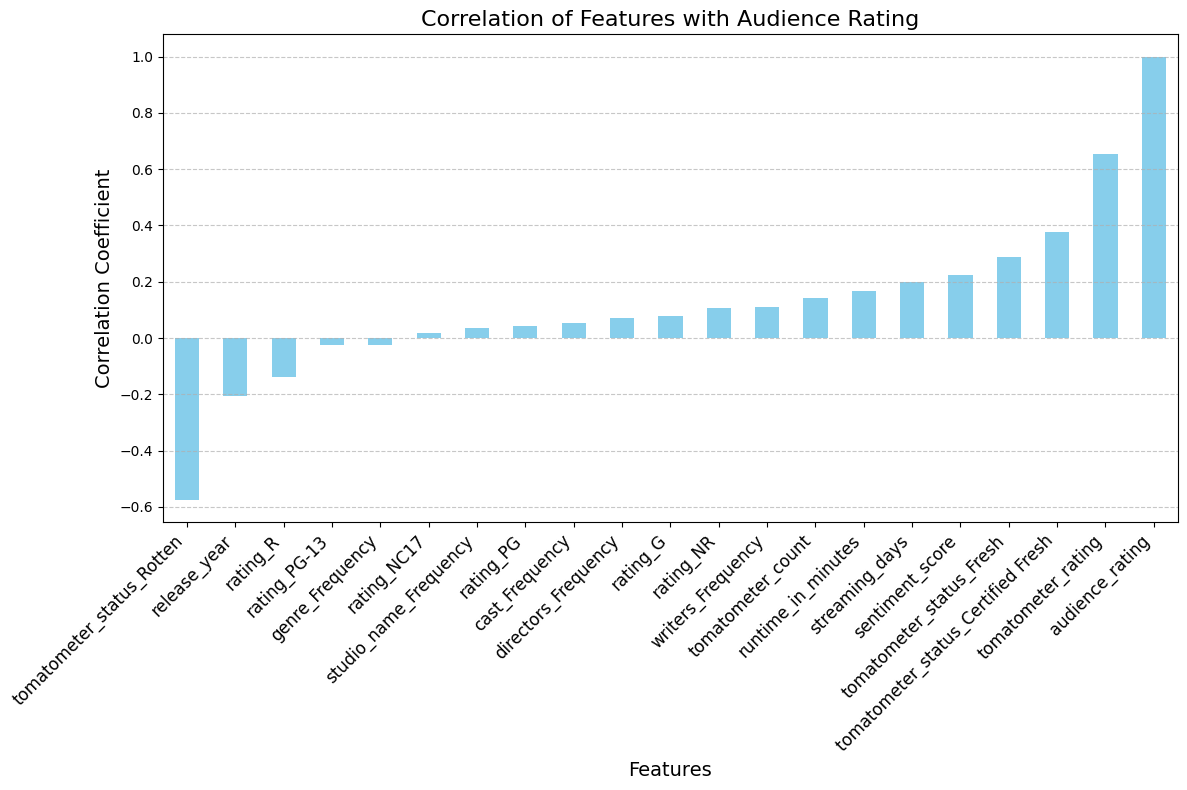

In [15]:
correlation_col_names = ['audience_rating','runtime_in_minutes', 'tomatometer_rating','tomatometer_count','rating_G','rating_NC17',
                         'rating_NR','rating_PG','rating_PG-13','rating_R','genre_Frequency','directors_Frequency','writers_Frequency',
                         'cast_Frequency', 'studio_name_Frequency', 'tomatometer_status_Certified Fresh','tomatometer_status_Fresh',
                         'tomatometer_status_Rotten','sentiment_score','release_year','streaming_days'] 

correlation_col = df[correlation_col_names]

# Compute the correlation matrix
correlation_matrix = correlation_col.corr()

# Extract the correlation of each column with the target column
target_column = 'audience_rating'
target_corr = correlation_matrix[target_column]

sorted_correlation = target_corr.sort_values()

plt.figure(figsize=(12, 8))
sorted_correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Audience Rating', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
selected_df = df.drop(['rating_PG-13','genre_Frequency','rating_NC17','studio_name_Frequency'],axis=1)
selected_df.head(2)

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,rating_G,rating_NR,rating_PG,rating_R,tomatometer_status_Certified Fresh,tomatometer_status_Fresh,...,work,world,writer,year,years,york,young,sentiment_score,release_year,streaming_days
0,83.0,49,144,53.0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245833,2010,137
1,90.0,86,140,64.0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,2010,172


# Normalization

In [17]:
from sklearn.model_selection import train_test_split

def normalize(df,col):
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

columns_to_normalize = ['runtime_in_minutes','tomatometer_rating','tomatometer_count','directors_Frequency',
                        'streaming_days']

normalized_df = normalize(selected_df,columns_to_normalize)



# Model Training

In [18]:
# Split the data into traning and test sets
X = normalized_df.drop('audience_rating', axis=1)
y = normalized_df['audience_rating'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
models = [LinearRegression(),
          RandomForestRegressor(),
          XGBRegressor(),
          GradientBoostingRegressor(),
          DecisionTreeRegressor()]

for model in models:
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print(f"********{type(model).__name__}*******")
    print("*******Train*******")
    print(f"MSE: {mean_squared_error(y_train,train_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train,train_pred))}")
    print(f"R2: {r2_score(y_train,train_pred)}")

    print(f"******Test******")
    print(f"MSE: {mean_squared_error(y_test,test_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test,test_pred))}")
    print(f"R2: {r2_score(y_test,test_pred)}")
    print("\n\n\n")

********LinearRegression*******
*******Train*******
MSE: 205.5045409540996
RMSE: 14.335429569918706
R2: 0.5029440018733522
******Test******
MSE: 208.59374521274444
RMSE: 14.44277484463233
R2: 0.4886506518500837




********RandomForestRegressor*******
*******Train*******
MSE: 27.532363406531996
RMSE: 5.247129063262309
R2: 0.9334071825844666
******Test******
MSE: 199.81248869754302
RMSE: 14.135504543437529
R2: 0.5101771352564093




********XGBRegressor*******
*******Train*******
MSE: 90.30893817142136
RMSE: 9.503101502742215
R2: 0.781568819870605
******Test******
MSE: 206.2447656009981
RMSE: 14.361224376807087
R2: 0.4944089702122133




********GradientBoostingRegressor*******
*******Train*******
MSE: 178.4233652818186
RMSE: 13.357520925748856
R2: 0.5684455267629422
******Test******
MSE: 196.56242857869285
RMSE: 14.020072345701104
R2: 0.5181443737827951




********DecisionTreeRegressor*******
*******Train*******
MSE: 1.8965851966245213e-32
RMSE: 1.3771656387757143e-16
R2: 1.0
******Te

In [20]:
# Hyperparameter Tuning
#       -Using grid search over hyperparameters, find the best parameters for the selected XGBRegressor model

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and the best score
print("Best parameters:", grid_search.best_params_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test,test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,test_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
MSE: 195.22066837309555
RMSE: 13.972139004930332
R2: 0.5214335817396585


# Model Pipeline

In [21]:
#     - Design the model pipeline using the best model with the optimal hyperparameters
#     - Run the model on the test set

# Create the pipeline with the best model (no preprocessing step as it is already processed)
pipeline = Pipeline(steps=[
    ('model', best_model)
])

pipeline.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_pred)

print("Evaluating on Test set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluating on Test set:
Mean Squared Error (MSE): 195.22066837309555
Root Mean Squared Error (RMSE): 13.972139004930332
R-squared (R²): 0.5214335817396585


In [22]:
# Custom Accuracy calculation using MAPE

# Calculate the absolute error
errors = abs(test_pred - y_test)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / y_test)

# Calculate the accuracy
accuracy = 100 - np.mean(mape)

print(f" Testing Accuracy: {round(accuracy, 2)} %")

 Testing Accuracy: 75.62 %
